# Random Forest Model

- Plot graphs showing training performance as a function of parameters

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [4]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [60]:
from kaggle_wrapper_lib import kaggle_competition_submit
from kaggle_wrapper_lib import kaggle_competition_submissions

In [5]:
from loan_approval_lib.standard_data_processing import data_cleaning_algorithm
from loan_approval_lib.standard_data_processing import create_loan_grade_numerical_from_loan_grade
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot
from loan_approval_lib.standard_data_processing import map_cb_person_default_on_file
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id
from loan_approval_lib.standard_data_processing import create_dataframe_copy_and_drop_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id

In [6]:
data = loan_approval_lib.load_original_data()

In [7]:
data_train = loan_approval_lib.load_data_train()

In [8]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning, Data Preprocessing

In [10]:
data = data_cleaning_algorithm(data)

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [12]:
data_train = data_cleaning_algorithm(data_train)

column person_age, number of removed rows: 1
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 2
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [14]:
data_cleaning_algorithm(data_test)
None

column person_age, number of removed rows: 0
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 0
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [15]:
# Loan Grade

create_loan_grade_numerical_from_loan_grade(data, data_train, data_test)

In [16]:
# Person Home Ownership

encoder = create_person_home_ownership_one_hot_encoder(data)

data = create_person_home_ownership_one_hot(encoder, data)
data_train = create_person_home_ownership_one_hot(encoder, data_train)
data_test = create_person_home_ownership_one_hot(encoder, data_test)

In [17]:
# Loan Intent

encoder = create_loan_intent_one_hot_encoder(data)

data = create_loan_intent_one_hot(encoder, data)
data_train = create_loan_intent_one_hot(encoder, data_train)
data_test = create_loan_intent_one_hot(encoder, data_test)

In [18]:
# Default On File

data = map_cb_person_default_on_file(data)
data_train = map_cb_person_default_on_file(data_train)
data_test = map_cb_person_default_on_file(data_test)

# Choose Columns for Tree Model, Copy DataFrame and Drop Unused Columns

In [19]:
decision_tree_columns = create_decision_tree_columns()
decision_tree_columns_with_id = create_decision_tree_columns_with_id()

In [20]:
data_copy = create_dataframe_copy_and_drop_columns(data)
data_train_copy = create_dataframe_copy_and_drop_columns(data_train)
data_test_copy = create_dataframe_copy_and_drop_columns(data_test)

# Random Forest Model

In [22]:
def random_forest_model_train(
    data_train,
    decision_tree_columns,
    n_estimators,
    max_features,
    max_depth,
    min_samples_split,
    min_samples_leaf,
    bootstrap,
    n_jobs,
):

    X = data_train[decision_tree_columns].copy()
    Y = data_train['loan_status'].copy()
    
    clf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        criterion='entropy',
        max_features=max_features,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        n_jobs=n_jobs,
        oob_score=True,
        
    )
    clf.fit(X, Y)
    
    Z = clf.predict(X)
    X['loan_status_predict'] = Z
    X['loan_status'] = data_train['loan_status']
    accuracy_in_sample = (X['loan_status'] == X['loan_status_predict']).sum() / len(X)
    
    return (clf, accuracy_in_sample)

In [23]:
def random_forest_model_test(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = clf.predict(X_test)
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy_out_of_sample = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy_out_of_sample

In [24]:
def random_forest_model_predict(
    clf,
    data_predict,
    decision_tree_columns,
    decision_tree_columns_with_id,
):
    
    X_predict = data_predict[decision_tree_columns_with_id].copy()

    Z_predict = clf.predict_proba(X_predict[decision_tree_columns])
    X_predict['loan_status'] = Z_predict[:, 1]

    return X_predict

In [25]:
def random_forest_model_predict_write_to_csv(
    data_predict,
    filename,
):
    data_predict[['id', 'loan_status']].to_csv(filename, index=False)

# Optimize Choice of Dataset

In [27]:
len(data_copy), len(data_train_copy), len(data_test_copy)

(28632, 58642, 39098)

In [28]:
'loan_status' in data_copy.columns, 'loan_status' in data_train_copy.columns, 'loan_status' in data_test_copy

(True, True, False)

In [29]:
28632 + 58642

87274

In [30]:
all_training_data = pandas.concat(
    [data_copy, data_train_copy],
    axis=0,
)
all_training_data.reset_index(inplace=True, drop=True)

In [32]:
permutation = numpy.random.permutation(all_training_data.index)

In [38]:
n_samples = len(all_training_data)
n_samples

87274

In [39]:
k = 5

In [41]:
fold_sizes = numpy.full(k, n_samples // k, dtype=int)
fold_sizes

array([17454, 17454, 17454, 17454, 17454])

In [43]:
fold_sizes[:n_samples % k] += 1
fold_sizes

array([17455, 17455, 17455, 17455, 17454])

In [45]:
index = 0
folds = []
for fold_size in fold_sizes:
    start = index
    stop = index + fold_size
    folds.append(permutation[start:stop])
    index = stop

In [ ]:
[
    1, 2, 3, 4, 5, 6, 7, 8, 9,
    10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,
    100, 150, 200, 300, 400, 500, 600, 700, 800,
    1000,
]

In [85]:
numpy.logspace(0, 10, num=20, endpoint=True, base=2.0, dtype=int)

array([   1,    1,    2,    2,    4,    6,    8,   12,   18,   26,   38,
         55,   79,  114,  165,  237,  342,  493,  710, 1024])

In [66]:
def kaggle_competition_submit_and_get_public_private_score_sync(filename, message):
    
    _ = kaggle_competition_submit(
        filename,
        message_tag
    )

    # TODO: Can make this faster with async logic
    while True:
        submissions = kaggle_competition_submissions()
        filtered_submissions = submissions[submissions['description'] == message_tag]
        assert len(filtered_submissions) == 1, f'invalid number of filtered submissions {len(filtered_submissions)}'
        status = filtered_submissions['status'][0]
        if status == 'SubmissionStatus.COMPLETE':
            break
        elif status == 'SubmissionStatus.PENDING':
            pass
        else:
            print(f'status={status}')

    public_score = filtered_submissions['publicScore'][0]
    private_score = filtered_submissions['privateScore'][0]

    return (public_score, private_score)

In [90]:
n_estimators_list = []
n_features_list = []
accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
oob_score_list = []
public_score_list = []
private_score_list = []

n_estimators = 1000
n_features = 'sqrt'

# for n_features in ['sqrt', 'log2', None]
# for n_estimators in 

n_estimators_list_input = [
    1, 2, 3, 4, 5, 6, 7, 8, 9,
    10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90,
    100, 150, 200, 300, 400, 500, 600, 700, 800,
    1000,
]

for n_features in ['sqrt', 'log2', None]:
    print(f'processing n_features={n_features}')
    #for n_estimators in [10, 20, 30, 50, 100, 200, 300, 500, 1000]
    for n_estimators in n_estimators_list_input:
        print(f'processing n_features={n_features}, n_estimators={n_estimators}')
        for i in range(k):
            test_index = folds[i]
            train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
        
            training_data = all_training_data.loc[train_index]
            test_data = all_training_data.loc[test_index]
            
            (
                clf,
                accuracy_in_sample,
            ) = random_forest_model_train(
                training_data,
                decision_tree_columns,
                n_estimators,
                n_features,
                None,
                10,
                4,
                True,
                8,
            )
        
            oob_score_ = clf.oob_score_
        
            accuracy_out_of_sample = random_forest_model_test(
                clf,
                test_data,
                decision_tree_columns,
            )
        
            n_estimators_list.append(n_estimators)
            n_features_list.append(n_features)
            accuracy_in_sample_list.append(accuracy_in_sample)
            accuracy_out_of_sample_list.append(accuracy_out_of_sample)
            oob_score_list.append(oob_score_)
        
            data_predict = random_forest_model_predict(
                clf,
                data_test_copy,
                decision_tree_columns,
                decision_tree_columns_with_id,
            )

            public_score = numpy.nan
            private_score = numpy.nan
            
            if False:
                filename = f'random_forest_model_features_{n_features}_estimators_{n_estimators}_fold_{i}_test.csv'
                message_tag = f'AUTO_TEST_random_forest_model_features_{n_features}_estimators_{n_estimators}_fold_{i}'
                
                random_forest_model_predict_write_to_csv(
                    data_predict,
                    filename,
                )
        
                public_score, private_score = kaggle_competition_submit_and_get_public_private_score_sync(filename, message)
            
            public_score_list.append(public_score)
            private_score_list.append(private_score)

processing n_features=sqrt
processing n_features=sqrt, n_estimators=1


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=2


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


processing n_features=sqrt, n_estimators=3


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=4


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=5


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=6


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=7


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=8


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=9


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=10


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=12


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=14


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=16


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=18


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=20


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=sqrt, n_estimators=25


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


processing n_features=sqrt, n_estimators=30


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


processing n_features=sqrt, n_estimators=35
processing n_features=sqrt, n_estimators=40
processing n_features=sqrt, n_estimators=45
processing n_features=sqrt, n_estimators=50
processing n_features=sqrt, n_estimators=60
processing n_features=sqrt, n_estimators=70
processing n_features=sqrt, n_estimators=80
processing n_features=sqrt, n_estimators=90
processing n_features=sqrt, n_estimators=100
processing n_features=sqrt, n_estimators=150
processing n_features=sqrt, n_estimators=200
processing n_features=sqrt, n_estimators=300
processing n_features=sqrt, n_estimators=400
processing n_features=sqrt, n_estimators=500
processing n_features=sqrt, n_estimators=600
processing n_features=sqrt, n_estimators=700
processing n_features=sqrt, n_estimators=800
processing n_features=sqrt, n_estimators=1000
processing n_features=log2
processing n_features=log2, n_estimators=1


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=2


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


processing n_features=log2, n_estimators=3


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=4


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=5


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=6


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=7


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=8


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=9


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=10


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=12


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=14


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=16


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=18


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=20


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=25


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=log2, n_estimators=30
processing n_features=log2, n_estimators=35
processing n_features=log2, n_estimators=40
processing n_features=log2, n_estimators=45
processing n_features=log2, n_estimators=50
processing n_features=log2, n_estimators=60
processing n_features=log2, n_estimators=70
processing n_features=log2, n_estimators=80
processing n_features=log2, n_estimators=90
processing n_features=log2, n_estimators=100
processing n_features=log2, n_estimators=150
processing n_features=log2, n_estimators=200
processing n_features=log2, n_estimators=300
processing n_features=log2, n_estimators=400
processing n_features=log2, n_estimators=500
processing n_features=log2, n_estimators=600
processing n_features=log2, n_estimators=700
processing n_features=log2, n_estimators=800
processing n_features=log2, n_estimators=1000
processing n_features=None
processing n_features=None, n_estimators=1


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=2


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=3


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=4


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=5


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=6


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=7


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=8


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=9


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=10


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=12


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=14


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=16


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=18


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=20


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: 

processing n_features=None, n_estimators=25


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


processing n_features=None, n_estimators=30


/home/edward/Jupyter/venv/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


processing n_features=None, n_estimators=35
processing n_features=None, n_estimators=40
processing n_features=None, n_estimators=45
processing n_features=None, n_estimators=50
processing n_features=None, n_estimators=60
processing n_features=None, n_estimators=70
processing n_features=None, n_estimators=80
processing n_features=None, n_estimators=90
processing n_features=None, n_estimators=100
processing n_features=None, n_estimators=150
processing n_features=None, n_estimators=200
processing n_features=None, n_estimators=300
processing n_features=None, n_estimators=400
processing n_features=None, n_estimators=500
processing n_features=None, n_estimators=600
processing n_features=None, n_estimators=700
processing n_features=None, n_estimators=800
processing n_features=None, n_estimators=1000


In [91]:
df = pandas.DataFrame(
    {
        'estimators': n_estimators_list,
        'features': n_features_list,
        'accuracy_in_sample': accuracy_in_sample_list,
        'accuracy_out_of_sample': accuracy_out_of_sample_list,
        'oob_score': oob_score_list,
        'public_score': public_score_list,
        'private_score': private_score_list,
    }
)

In [100]:
df.loc[df['features'].isna(), 'features'] = 'none'

In [101]:
df

,estimators,features,accuracy_in_sample,accuracy_out_of_sample,oob_score,public_score,private_score
0,1,sqrt,0.937868,0.923861,0.865481,NaN,NaN
1,1,sqrt,0.937553,0.919335,0.864908,NaN,NaN
2,1,sqrt,0.937854,0.917158,0.866856,NaN,NaN
3,1,sqrt,0.936206,0.920997,0.864206,NaN,NaN
4,1,sqrt,0.938155,0.920305,0.867087,NaN,NaN
...,...,...,...,...,...,...,...
520,1000,none,0.960154,0.948324,0.946103,NaN,NaN
521,1000,none,0.960971,0.946491,0.947006,NaN,NaN
522,1000,none,0.961457,0.945460,0.947020,NaN,NaN
523,1000,none,0.961572,0.947178,0.946977,NaN,NaN


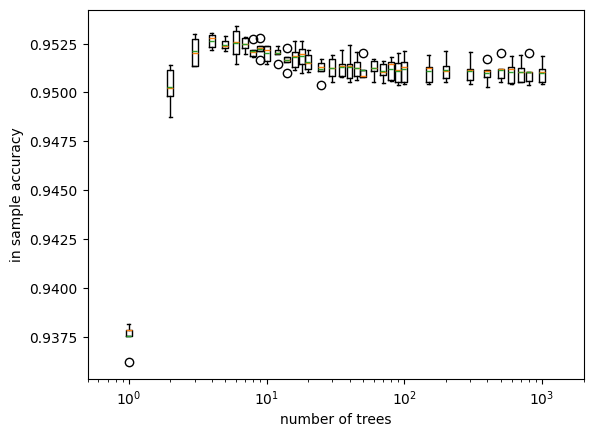

In [122]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_in_sample']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.5, xmax=2000)
plt.xlabel('number of trees')
plt.ylabel('in sample accuracy')

None

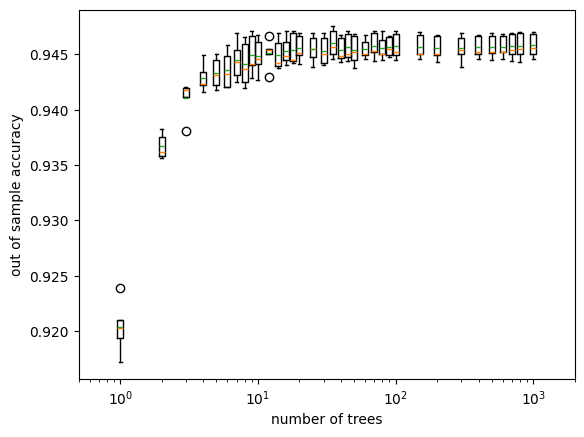

In [123]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['accuracy_out_of_sample']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.5, xmax=2000)
plt.xlabel('number of trees')
plt.ylabel('out of sample accuracy')

None

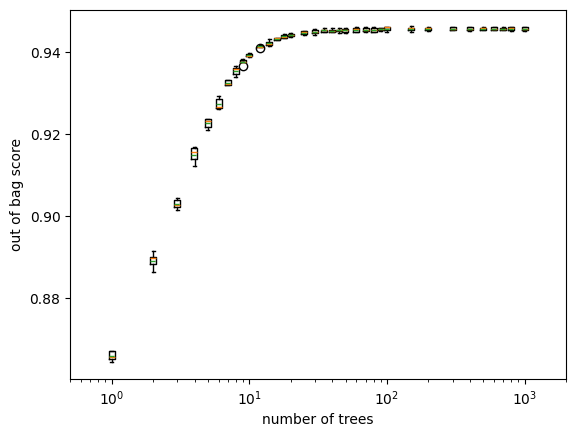

In [124]:
plt.figure()

df_select = df[df['features'] == 'sqrt']

positions = []
x = []

for estimators_ in sorted(df_select['estimators'].unique()):
    x.append(
        df_select[df_select['estimators'] == estimators_]['oob_score']
    )
    positions.append(
        estimators_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.5, xmax=2000)
plt.xlabel('number of trees')
plt.ylabel('out of bag score')

None

# Plot mean

In [102]:
df_aggregated = df.groupby(
    by=['estimators', 'features']
).aggregate(
    {
        'accuracy_in_sample': [('accuracy_in_sample_mean', 'mean')],
        'accuracy_out_of_sample': [('accuracy_out_of_sample', 'mean')],
        'oob_score': [('oob_score', 'mean')],
        'public_score': [('public_score', 'mean')],
        'private_score': [('private_score', 'mean')],
    }
)

df_aggregated.columns = [column[1] for column in df_aggregated.columns]

df_aggregated.reset_index(inplace=True)

In [103]:
df_aggregated

,estimators,features,accuracy_in_sample_mean,accuracy_out_of_sample,oob_score
0,1,log2,0.937292,0.919976,0.864579
1,1,none,0.945723,0.919094,0.864639
2,1,sqrt,0.937527,0.920331,0.865707
3,2,log2,0.949945,0.935731,0.887452
4,2,none,0.958295,0.937851,0.887598
...,...,...,...,...,...
100,800,none,0.961002,0.946605,0.946740
101,800,sqrt,0.951025,0.945757,0.945545
102,1000,log2,0.951002,0.945688,0.945582
103,1000,none,0.961074,0.946662,0.946771
